In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
params = {} 
params["dataset_directory"] = "/raw-spiking-heidleberg-digits-80input/"
params["verbose"] = False

In [7]:
x_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_x_spikes.npy", allow_pickle = True)
y_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_y_spikes.npy", allow_pickle = True)

x_test = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/testing_x_spikes.npy", allow_pickle = True)
training_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "training_details.csv")
testing_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "testing_details.csv")


In [8]:
x_train.shape

(8156,)

In [9]:
x_test.shape

(2264,)

In [16]:
if params["verbose"]: print(training_details.head())
speaker_id = np.sort(training_details.Speaker.unique())
speaker_id = speaker_id = speaker_id.astype('int8')  #np where is fussy with int
if params["verbose"]: print(np.sort(testing_details.Speaker.unique()))
speaker = list(training_details.loc[:, "Speaker"])

In [17]:
speaker_id = np.sort(training_details.Speaker.unique())
speaker_id = speaker_id.astype('int8')  #np where is fussy with int
print(speaker_id)

[ 0  1  2  3  6  7  8  9 10 11]


In [18]:
speaker_x_indexes_list = [[] for _ in range(20)]
speaker_x_digit_2_indexes_list = [[] for _ in range(20)]

In [19]:
for s in speaker_id:
    speaker_x_indexes_list[s] = np.where(np.array(speaker) == s)[0]
    speaker_x_digit_2_indexes_list[s] = np.where(np.array(y_train[speaker_x_indexes_list[s]]) == 2)[0]

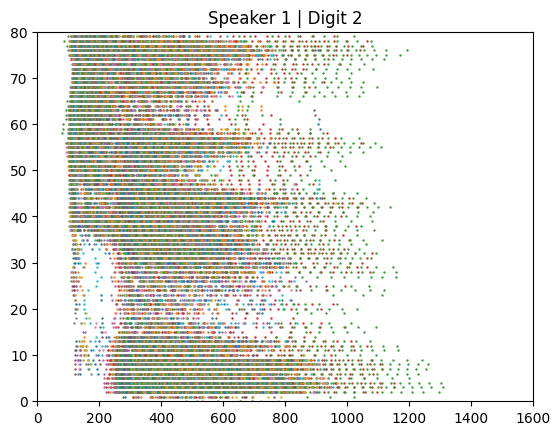

In [20]:
display_speaker = 1
for s in range(speaker_x_digit_2_indexes_list[display_speaker].shape[0]):

    plt.scatter(x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["t"], 
                x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["x"], 
                s = 0.5)

plt.ylim(0, 80)
plt.xlim(0, 1600)
plt.title(f"Speaker {display_speaker} | Digit 2")

plt.show()

In [21]:
print(speaker_id)

[ 0  1  2  3  6  7  8  9 10 11]


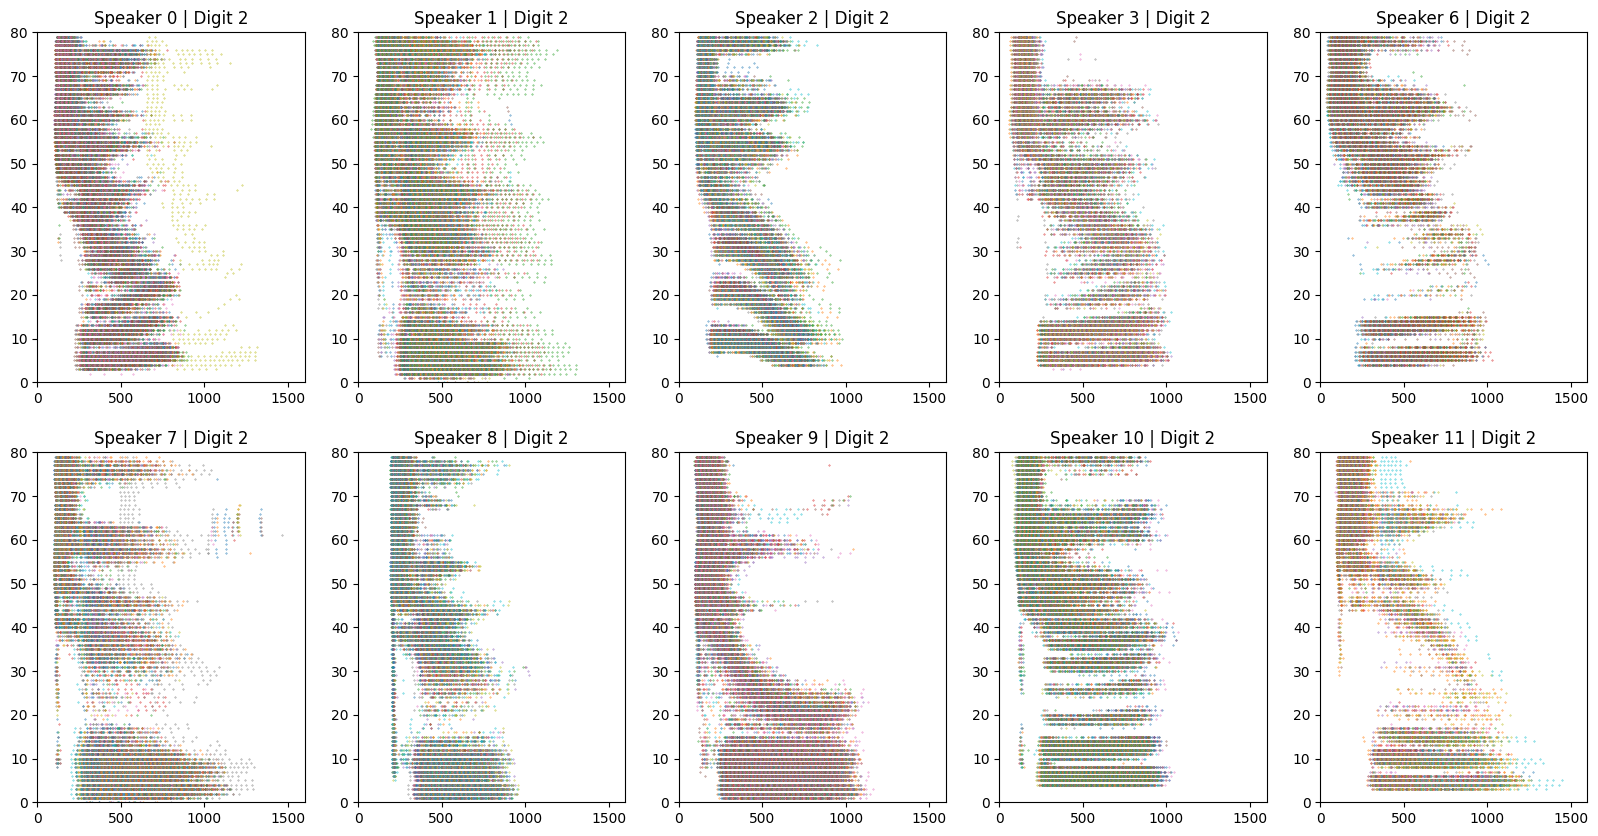

In [22]:
plt.figure(figsize=(20, 10), dpi=100)

count = 0

for display_speaker in speaker_id:
    count += 1
    #display_speaker = 1
    plt.subplot(2, 5, count)
    for s in range(speaker_x_digit_2_indexes_list[display_speaker].shape[0]):

        plt.scatter(x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["t"], 
                    x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["x"], 
                    s = 0.1)

    plt.ylim(0, 80)
    plt.xlim(0, 1600)
    plt.title(f"Speaker {display_speaker} | Digit 2")
    
plt.show()

In [23]:
from elephant.spike_train_generation import homogeneous_poisson_process

In [24]:
import numpy as np
import quantities as pq
from neo.core import SpikeTrain
from elephant.spike_train_dissimilarity import van_rossum_distance

def get_vr_distance(spike_train1, spike_train2, tau_val = 10.0, last_spike_t = 1600):
    
    t1 = np.sort(spike_train1['t']) * pq.ms  
    t2 = np.sort(spike_train2['t']) * pq.ms

    st_a = SpikeTrain(t1, t_stop=last_spike_t * pq.ms)
    st_b = SpikeTrain(t2, t_stop=last_spike_t * pq.ms)

    # time constant of the exponential kernel (10?)
    tau = tau_val * pq.ms

    vr = van_rossum_distance([st_a, st_b], tau)
    
    return vr[0, 1]

In [25]:
vr_distance = get_vr_distance(x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][0],
                              x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][1])

print(f"Van Rossum Distance: {vr_distance:.4f}")

Van Rossum Distance: 44.7796


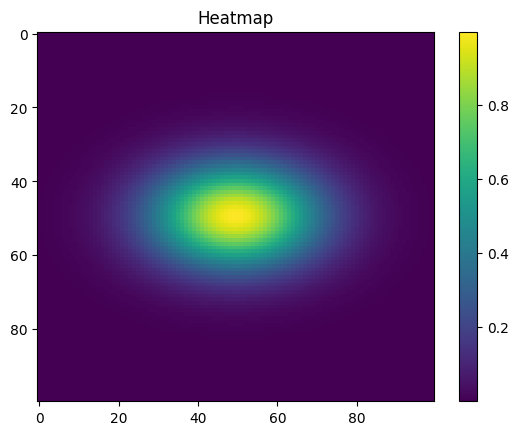

In [26]:
import numpy as np

def gaussian_kernel(T, X, sigma_t, sigma_x):
    return np.exp(- (T**2 / (2 * sigma_t**2)) - (X**2 / (2 * sigma_x**2)))

# Example usage:
T, X = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
sigma_t, sigma_x = 1.0, 1.5  # Standard deviations
kernel = gaussian_kernel(T, X, sigma_t, sigma_x)


plt.imshow(np.flip(np.swapaxes(kernel, 1, 0), 0), aspect = 'auto')
plt.colorbar()
plt.title('Heatmap')
plt.show()

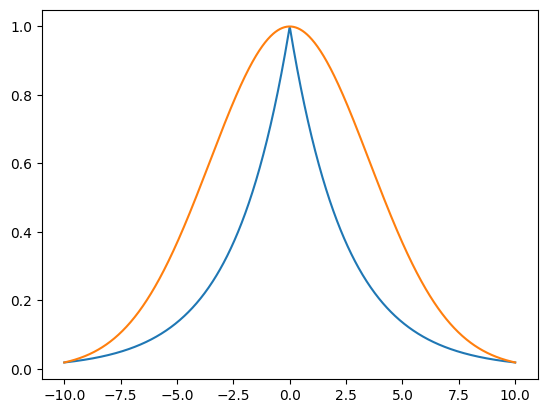

In [27]:
x = np.linspace(-10, 10, 1000)

beta = 5
sigma_x = 5.0

plt.plot(x, np.exp(-np.abs(x) / beta) * np.exp(-np.abs(x) / beta))
plt.plot(x, np.exp(- (x**2 / (2 * sigma_x**2)) - (x**2 / (2 * sigma_x**2))))

# Show the plot
plt.show()

In [ ]:
import numpy as np
import quantities as pq
from neo.core import SpikeTrain
from scipy.signal import convolve2d
from elephant.spike_train_dissimilarity import van_rossum_distance

def exponential_kernel_2d(size_t, size_x, tau_t, tau_x):
    t = np.linspace(-size_t/2, size_t/2, size_t + 1, dtype='int8')
    x = np.linspace(-size_x/2, size_x/2, size_x + 1, dtype = 'int8')
    
    T, X = np.meshgrid(t, x, indexing='ij')
    
    kernel = np.exp(-np.abs(T) / tau_t) * np.exp(-np.abs(X) / tau_x)
    
    # 3D Surface plot
    fig = plt.figure(figsize=(12, 5))
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(T, X, kernel, cmap='viridis', edgecolor='none')
    ax2.set_title("3D Surface Plot of Kernel")

    plt.show() 
    
    return kernel / np.sum(kernel)  # Normalize kernel

def gaussian_kernel_2d(size_t, size_x, sigma_t = 10, sigma_x = 10):

    t = np.arange(-size_t // 2, size_t // 2 + 1)
    x = np.arange(-size_x // 2, size_x // 2 + 1)

    T, X = np.meshgrid(t, x, indexing='ij')

    kernel = np.exp(-((T**2) / (2 * sigma_t**2) + (X**2) / (2 * sigma_x**2)))
    kernel /= np.sum(kernel)

    # Plot kernel
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, kernel, cmap='viridis', edgecolor='none')
    ax.set_ylabel("Y axis")
    ax.set_xlabel("X axis")
    plt.show()
    
    return kernel

def get_vr_distance_2d(spike_train1, 
                       spike_train2, 
                       tau_t = 40, 
                       tau_x = 20,
                       size_t = 40,
                       size_x = 10, 
                       last_spike_t = 1600, 
                       num_neurons = 80):
    
    time_bins = np.arange(0, last_spike_t + 1, 1)  # 1 ms bins
    spike_matrix1 = np.zeros((len(time_bins), num_neurons))
    spike_matrix2 = np.zeros((len(time_bins), num_neurons))

    for t, x in zip(spike_train1['t'], spike_train1['x']):
        spike_matrix1[int(t), int(x)] = 1
    for t, x in zip(spike_train2['t'], spike_train2['x']):
        spike_matrix2[int(t), int(x)] = 1
    
    #kernel = exponential_kernel_2d(size_t = size_t, size_x = size_x, tau_t=tau_t, tau_x=tau_x)
    kernel = gaussian_kernel_2d(size_t = size_t, size_x = size_x, sigma_x = tau_x, sigma_t = tau_t)
    
    smoothed1 = convolve2d(spike_matrix1, kernel, mode='same', boundary='wrap')
    smoothed2 = convolve2d(spike_matrix2, kernel, mode='same', boundary='wrap')
    
    # Compute Euclidean distance between smoothed spike matrices
    distance = np.linalg.norm(smoothed1 - smoothed2)
    
    return distance, smoothed1, kernel

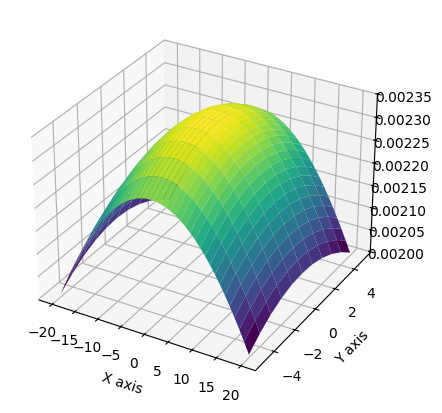

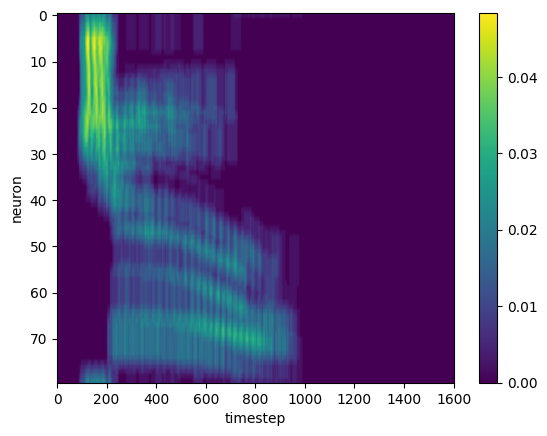

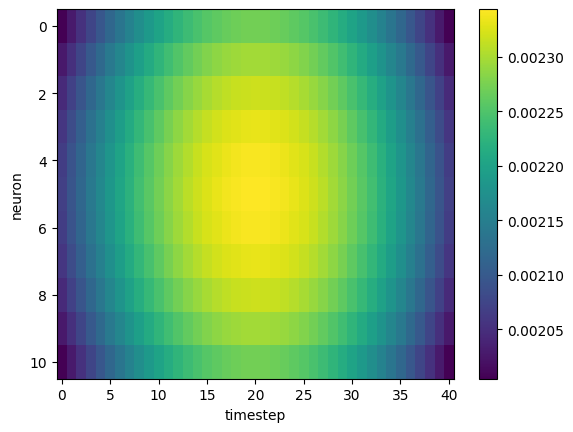

In [47]:
distance, smoothed1, kernel = get_vr_distance_2d(x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][1],
                                                 x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][2])

plt.imshow(np.flip(np.swapaxes(smoothed1, 1, 0), 0), aspect = 'auto')
plt.colorbar()
plt.ylabel("neuron")
plt.xlabel("timestep")
plt.show()

plt.imshow(np.flip(np.swapaxes(kernel, 1, 0), 0), aspect = 'auto')
plt.ylabel("neuron")
plt.xlabel("timestep")
plt.colorbar()
plt.show()

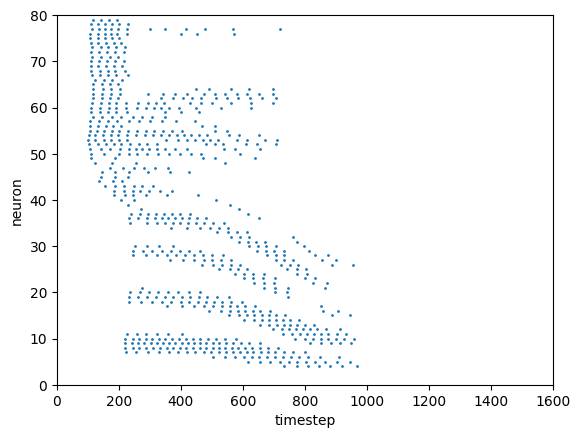

In [48]:
plt.scatter(x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][1]['t'], 
            x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][1]['x'],
            s = 1)
plt.ylim(0, 80)
plt.xlim(0, 1600)
plt.ylabel("neuron")
plt.xlabel("timestep")
plt.show()

In [31]:
vr_combined_speakers_list = [0 for _ in range(20)]
count_list = [0 for _ in range(20)]

# for 2D kernel, this took 23m37s. 
for display_speaker in speaker_id:
    print(display_speaker)
    for s_i in range(y_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]].shape[0]):
        for s_j in range(y_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]].shape[0]):
            if s_i == s_j: continue
            
            count_list[display_speaker] += 1
            
            vr_combined_speakers_list[display_speaker] += get_vr_distance(x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][s_i],
                                                                          x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][s_j])
            
    vr_combined_speakers_list[display_speaker] /= count_list[display_speaker]
    

0
1
2
3
6
7
8
9
10
11


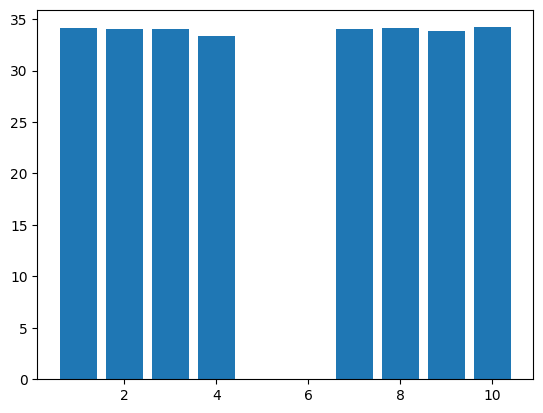

In [32]:
plt.bar([1,2,3,4,5,6,7,8,9,10], vr_combined_speakers_list[0:10])
plt.show()

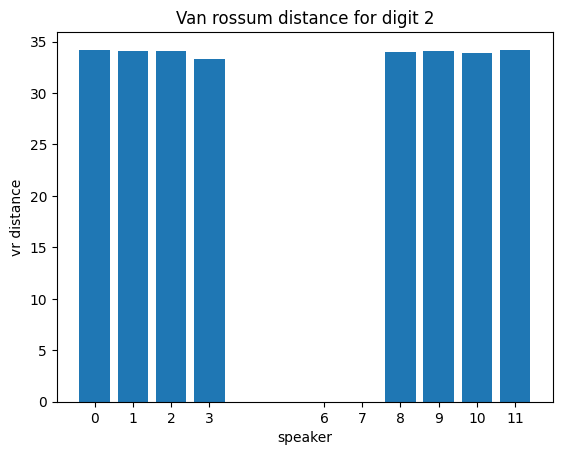

In [33]:
plt.bar(np.sort(training_details.Speaker.unique()), vr_combined_speakers_list[0:10])

plt.ylabel("vr distance")
plt.xlabel("speaker")
plt.xticks(np.sort(training_details.Speaker.unique()))
plt.title("Van rossum distance for digit 2")
plt.show()

In [34]:
vr_combined_speakers_list


[34.173162767957855,
 34.042859930123825,
 34.057979940515665,
 33.31201490024179,
 0,
 0,
 34.031823432428574,
 34.09735424228406,
 33.852949063277386,
 34.205403914382735,
 34.042859930123825,
 33.96508062207413,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [35]:
vr_distance = get_vr_distance(x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][0],
                              x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][1])

print(f"Van Rossum Distance: {vr_distance:.4f}")

Van Rossum Distance: 44.7796


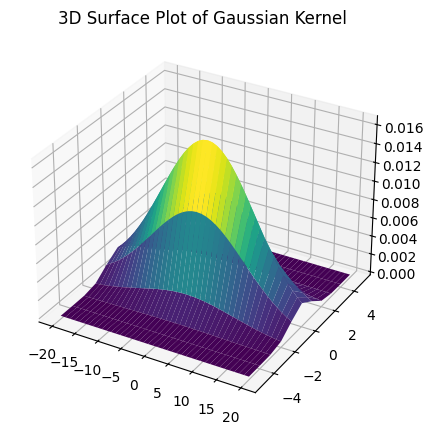

Van Rossum Distance: 3.1881


In [36]:
vr_distance = get_vr_distance_2d(x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][0], 
                                 x_train[speaker_x_indexes_list[0]][speaker_x_digit_2_indexes_list[0]][4],
                                 tau_t = 10.0,
                                 tau_x = 1.0)

print(f"Van Rossum Distance: {vr_distance[0]:.4f}")

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
a = x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][0]
b = x_train[speaker_x_indexes_list[2]][speaker_x_digit_2_indexes_list[2]][1]

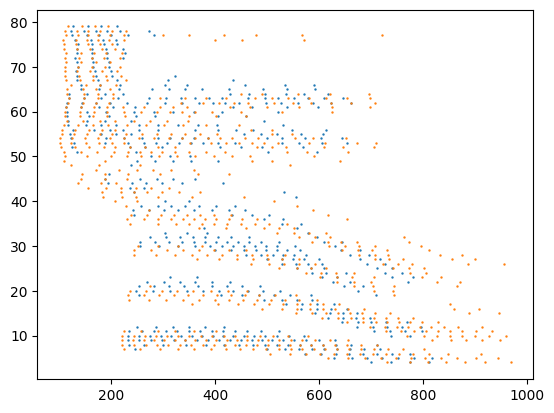

In [39]:
plt.scatter(a['t'], a['x'], s = 0.5)
plt.scatter(b['t'], b['x'], s = 0.5)
plt.show()

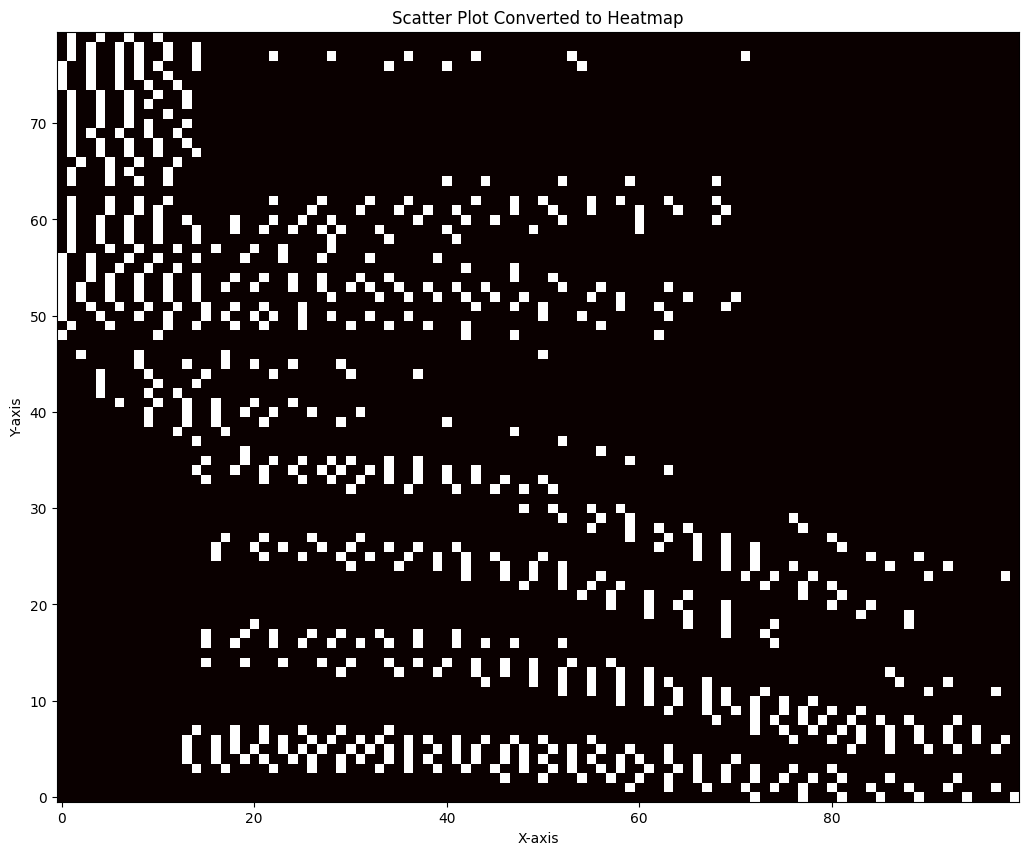

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10), dpi=100)

# Convert scatter plot to heatmap using a 2D histogram
a_heatmap, xedges, yedges = np.histogram2d(a['t'], a['x'], bins=(100, 80))
b_heatmap, xedges, yedges = np.histogram2d(b['t'], b['x'], bins=(100, 80))

# Plot heatmap
plt.imshow(a_heatmap.T, origin='lower', cmap='hot', interpolation='nearest')
plt.imshow(b_heatmap.T, origin='lower', cmap='hot', interpolation='nearest')
#plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot Converted to Heatmap')
plt.show()